<a href="https://colab.research.google.com/github/aupe/dl_cv_plant_seedlings/blob/master/dl_cv_plant_seedlings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Seedlings Classification

Can you differentiate a weed from a crop seedling?

The ability to do so effectively can mean better crop yields and better stewardship of the environment.

The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of approximately 960 unique plants belonging to 12 species at several growth stages.

Dataset is taken from https://www.kaggle.com/c/plant-seedlings-classification

### Table of content
Imports & data download

EDA

*  Number of images and labels
*  Visualizing images from each category
*  Image distribution by label
*  Image shape distribution

Image data preprocessing

Modelling

*  First Model - Xception
*  Second Model - Xception
*  DenseNet121, MobileNetV2, EfficientNetB6
*  HP tuning
*  Third Model - Xception
*  Fourth Model - Xception
*  Model Xception with no weights
*  Final Model - Xception

Predicting Kaggle competition set (unlabled images)

*  Reading and exploring the data
*  Predicting with Final Model
*  Unlabeled images prediction analysis

    * Distribution by category
    * Plotting random images and showing predicted label
    
*  Kaggle submission score







## Imports & data download

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1
!pip install -q -U --pre efficientnet
!pip install -q -U toai

In [0]:
# Kaggle data import
def setup_kaggle():
    !rm -rf /root/.kaggle
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    
setup_kaggle()

In [0]:
from toai.imports import *
from toai.data import DataParams, DataContainer
from toai.models import save_keras_model, load_keras_model
from toai.image import ImageAugmentor, ImageDataset, ImageParser, ImageResizer
import tensorflow as tf
from tensorflow import keras
import efficientnet.tfkeras as efn
import os
from toai.metrics import sparse_top_2_categorical_accuracy

In [9]:
tf.__version__

'2.0.0-beta1'

In [0]:
DATA_DIR = Path('data/plants')
TEMP_DIR = Path('./gdrive/My Drive/Projects/08_Plant_seedlings/temp/plants')

In [0]:
DATA_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
# TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [14]:
!kaggle competitions download -c plant-seedlings-classification -p {str(DATA_DIR)}

  0% 0.00/5.13k [00:00<?, ?B/s]
100% 5.13k/5.13k [00:00<00:00, 4.45MB/s]
100% 86.0M/86.0M [00:01<00:00, 48.4MB/s]

 99% 1.58G/1.60G [00:32<00:00, 46.6MB/s]
100% 1.60G/1.60G [00:33<00:00, 51.9MB/s]


In [0]:
!unzip -q {str(DATA_DIR)}/train.zip -d {str(DATA_DIR)}

# EDA

## Number of images and labels

In [0]:
def make_df_from_dir_with_dim(path):
    data = {
        'category': [],
        'path':[],
        'shape': [], 
    }
    for category in os.listdir(DATA_DIR/path):
        for item in os.listdir(DATA_DIR/path/category):
            data['category'].append(category)
            data['path'].append(f"{DATA_DIR}/{path}/{category}/{item}")            
            data['shape'].append(np.array(Image.open(DATA_DIR/path/category/item)).shape)
                      
    return pd.DataFrame(data)

In [0]:
df_full = make_df_from_dir_with_dim('train')

In [23]:
df_full.head(3)

category                                      path          shape
0  Charlock  data/plants/train/Charlock/c291766ce.png  (485, 485, 3)
1  Charlock  data/plants/train/Charlock/c9a504525.png  (935, 935, 3)
2  Charlock  data/plants/train/Charlock/8194f9c87.png  (552, 552, 3)

In [0]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 4 columns):
category    4750 non-null object
image       4750 non-null object
path        4750 non-null object
shape       4750 non-null object
dtypes: object(4)
memory usage: 148.5+ KB


In [20]:
df_full.category.unique()

array(['Charlock', 'Loose Silky-bent', 'Sugar beet', 'Maize', 'Cleavers',
       'Common Chickweed', 'Black-grass', 'Fat Hen',
       'Small-flowered Cranesbill', 'Shepherds Purse', 'Common wheat',
       'Scentless Mayweed'], dtype=object)

In [0]:
df_full.category.nunique()

12

In [0]:
df_full.to_csv(TEMP_DIR/'df_full.csv', index=False)

In [0]:
df_full = pd.read_csv(TEMP_DIR/'df_full.csv')

## Visualizing images from each category



In [0]:
def plot_df_images_c(df, path_col, label_col, n_columns, pred_col=False):
    n_rows = math.ceil(df[label_col].nunique() // n_columns)
    f,ax = plt.subplots(n_rows,n_columns, figsize=(4 * n_columns, 4 * n_rows))
    cat = np.sort(df[label_col].unique())
    for i in range(df[label_col].nunique()):
        ax[i // n_columns, i % n_columns].imshow(np.array(Image.open(df[df[label_col] == cat[i]].sample()[path_col].item())))
        ax[i // n_columns, i % n_columns].axis('off')
        ax[i // n_columns, i % n_columns].set_title(cat[i])

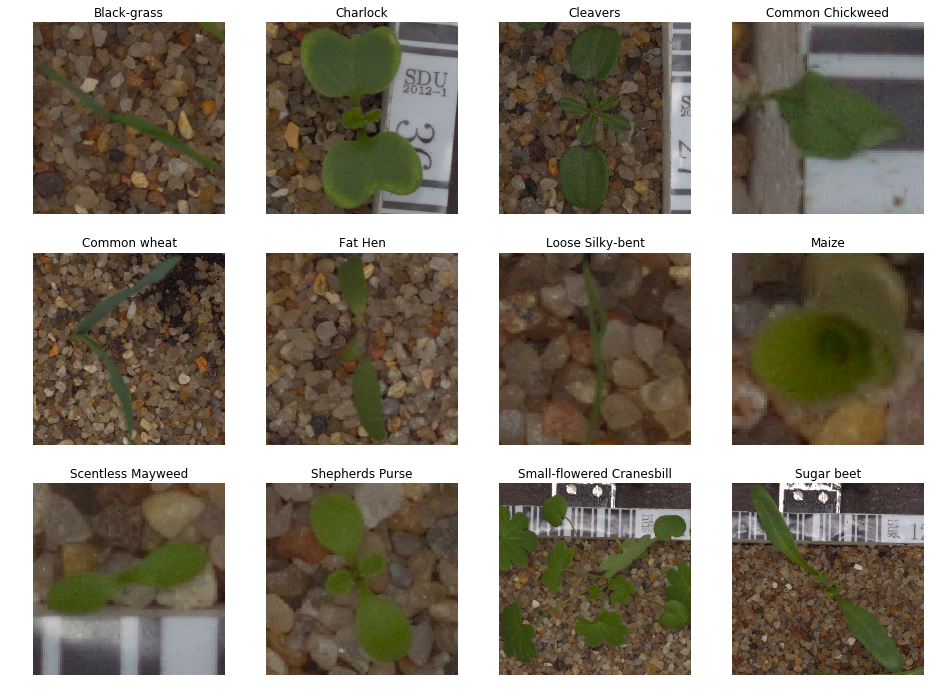

In [0]:
plot_df_images_c(df_full, 'path', 'category', 4)

## Image distribution by label




In [0]:
df_full.groupby('category')['path'].nunique()

category
Black-grass                  263
Charlock                     390
Cleavers                     287
Common Chickweed             611
Common wheat                 221
Fat Hen                      475
Loose Silky-bent             654
Maize                        221
Scentless Mayweed            516
Shepherds Purse              231
Small-flowered Cranesbill    496
Sugar beet                   385
Name: path, dtype: int64

Text(0.5, 1.0, 'All images distribution by category')

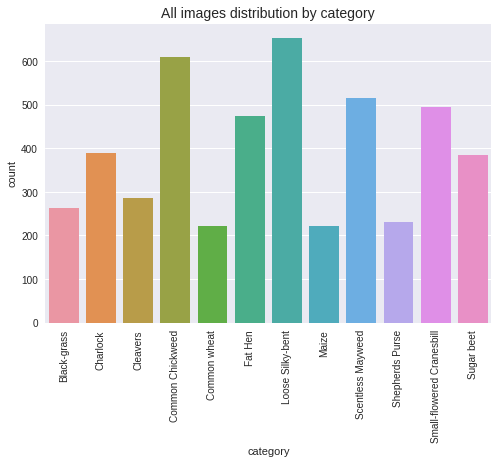

In [0]:
plt.style.use('seaborn')
sns.countplot(df_full['category'].sort_values(), data=df_full)
plt.xticks(rotation=90)
plt.title('All images distribution by category', fontsize=14)

## Image shape distribution

In [0]:
df_full.groupby('shape')['path'].nunique()

shape
(100, 100, 3)      19
(1000, 1000, 3)     2
(1004, 1004, 3)     1
(1005, 1005, 3)     1
(1005, 1006, 3)     2
(1006, 1006, 3)     2
(1007, 1007, 3)     2
(1008, 1008, 3)     1
(1009, 1009, 3)     1
(101, 101, 3)      19
(1010, 1010, 3)     3
(1016, 1016, 3)     1
(102, 102, 3)      11
(1020, 1020, 3)     1
(1022, 1022, 3)     1
(1023, 1023, 3)     2
(1026, 1026, 3)     1
(1029, 1029, 3)     2
(103, 103, 3)      13
(1030, 1030, 3)     1
(1034, 1034, 3)     3
(1035, 1035, 3)     1
(1036, 1036, 3)     2
(1037, 1037, 3)     2
(1038, 1038, 3)     3
(104, 104, 3)      13
(1040, 1040, 3)     1
(1041, 1041, 3)     1
(1044, 1044, 3)     1
(1045, 1045, 3)     5
                   ..
(95, 95, 3)        17
(950, 950, 3)       1
(955, 955, 3)       2
(957, 957, 3)       1
(958, 958, 3)       1
(959, 959, 3)       2
(96, 96, 3)        11
(960, 960, 3)       1
(961, 961, 3)       1
(962, 962, 3)       1
(965, 965, 3)       1
(966, 966, 3)       1
(967, 967, 3)       3
(968, 968, 3)       1
(97,

In [0]:
df_full.groupby('shape')['path'].nunique().reset_index().sort_values(by='path', ascending=False).head()

shape  path
76   (115, 115, 3)    34
156  (137, 137, 3)    29
199  (155, 155, 3)    27
102  (121, 121, 3)    26
196  (154, 154, 3)    25

In [24]:
df_full.groupby('shape')['path'].nunique().reset_index().sort_values(by='path', ascending=False).tail(3)

shape  path
711     (623, 623, 3)     1
52    (1101, 1101, 3)     1
1006    (993, 993, 3)     1

# Image data preprocessing

In [0]:
train_data, val_data = train_test_split(df_full[['category', 'path']], test_size=0.4, random_state=42, stratify=df_full["category"])
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42, stratify=val_data["category"])

In [0]:
[x.shape for x in (train_data, val_data, test_data)]

[(2850, 2), (950, 2), (950, 2)]

In [0]:
train_data.to_csv(TEMP_DIR/'train_data.csv', index=False)
val_data.to_csv(TEMP_DIR/'val_data.csv', index=False)
test_data.to_csv(TEMP_DIR/'test_data.csv', index=False)

In [0]:
train_data = pd.read_csv(TEMP_DIR/'train_data.csv')
val_data = pd.read_csv(TEMP_DIR/'val_data.csv')
test_data = pd.read_csv(TEMP_DIR/'test_data.csv')

In [0]:
train_data.head(3)

category                                               path
0       Common wheat       data/plants/train/Common wheat/c97e74bd0.png
1  Scentless Mayweed  data/plants/train/Scentless Mayweed/2de4ec934.png
2    Shepherds Purse    data/plants/train/Shepherds Purse/02afc3d7a.png

In [0]:
val_data.head(3)

category                                      path
0  Cleavers  data/plants/train/Cleavers/1526846f7.png
1   Fat Hen   data/plants/train/Fat Hen/5f2ad45c4.png
2   Fat Hen   data/plants/train/Fat Hen/a1a3e2515.png

In [0]:
test_data.head(3)

category                                             path
0  Shepherds Purse  data/plants/train/Shepherds Purse/1c95a2c57.png
1         Cleavers         data/plants/train/Cleavers/c3b79748e.png
2         Charlock         data/plants/train/Charlock/4537042f3.png

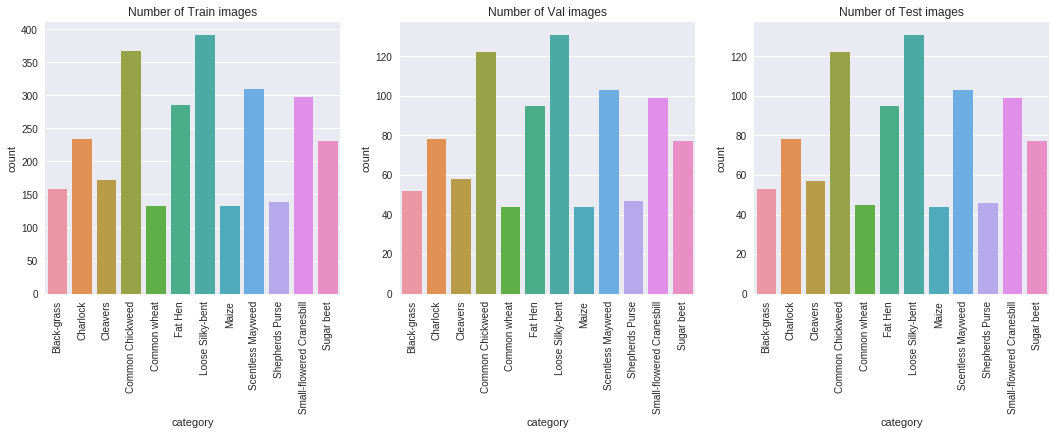

In [0]:
f, ax = plt.subplots(1, 3, figsize=(18, 5))
plt.style.use('seaborn')
sns.countplot(train_data['category'].sort_values(),data=train_data, ax=ax[0])
sns.countplot(val_data['category'].sort_values(),data=val_data, ax=ax[1])
sns.countplot(test_data['category'].sort_values(),data=test_data, ax=ax[2])
ax[0].set_title('Number of Train images')
ax[1].set_title('Number of Val images')
ax[2].set_title('Number of Test images')
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)
ax[2].tick_params(axis='x', rotation=90)

In [0]:
target_col = 'category'
img_col='path'

In [0]:
label_pipeline = LabelEncoder()

In [0]:
label_pipeline.fit_transform(train_data[target_col])

array([4, 8, 9, ..., 1, 1, 1])

In [0]:
with open(TEMP_DIR/"label_pipeline.pickle", "wb") as f:
    pickle.dump(label_pipeline, f)

In [0]:
with open(TEMP_DIR/"label_pipeline.pickle", "rb") as f:
    label_pipeline = pickle.load(f)

In [0]:
IMG_DIMS = (224, 224, 3)

In [0]:
data_container_1 = DataContainer(
    train=ImageDataset(
        x=train_data[img_col].values,
        y=label_pipeline.transform(train_data[target_col]),
        batch_size=2,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=2, flips="both"),
        ],
        shuffle=True,
        prefetch=0,
        num_parallel_calls=1,
    ),
    validation=ImageDataset(
        x=val_data[img_col].values,
        y=label_pipeline.transform(val_data[target_col]),
        img_dims=IMG_DIMS,
        batch_size=2,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
        ],
        shuffle=False,
        prefetch=0,
        num_parallel_calls=-1,
    ),
    test=ImageDataset(
        x=test_data[img_col].values,
        y=label_pipeline.transform(test_data[target_col]),
        img_dims=IMG_DIMS,
        batch_size=2,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
        ],
        shuffle=False,
        prefetch=0,
        num_parallel_calls=-1,
    ),
)

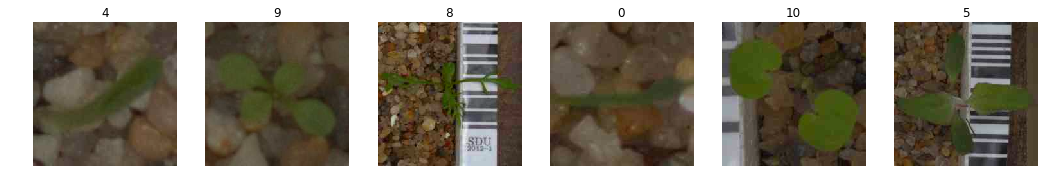

In [0]:
data_container.train.show(n_batches=3)

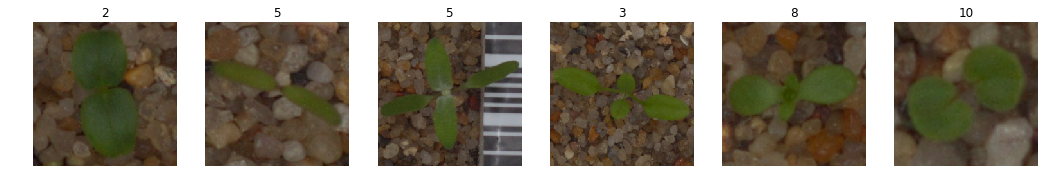

In [0]:
data_container.validation.show(n_batches=3)

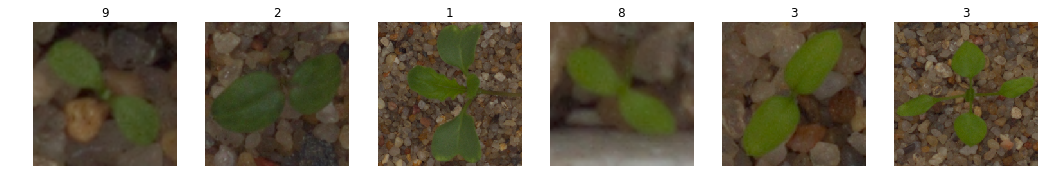

In [0]:
data_container.test.show(n_batches=3)

# Modelling

## First model - Xception

```
IMG_DIMS = (224, 224, 3)
lrs=(1e-4, 1e-4)
dropout=0.5
l1=1e-8,
l2=1e-8,
epochs=(3, 10)
```



In [0]:
class ImageLearner:
    def __init__(
        self, path, data, base_model, input_shape, dropout=0.0, l1=1e-8, l2=1e-8, override=False, load=False,
    ):
        self.path = str(path)
        self.weights_path = f"{self.path}/weights.h5"
        self.architecture_path = f"{self.path}/model.json"
        self.logs_path = f"{self.path}/logs"

        self.data = data
        self.n_classes = data.train.n_classes
        self.input_shape = input_shape
        self.dropout = dropout
        self.l1 = l1
        self.l2 = l2

        self.base_model = base_model(include_top=False, input_shape=input_shape)
        x = keras.layers.concatenate(
            [
                keras.layers.GlobalAvgPool2D()(self.base_model.output),
                keras.layers.GlobalMaxPool2D()(self.base_model.output),
            ]
        )
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(dropout)(x)
        x = keras.layers.Dense(
            self.n_classes,
            kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
            activation=keras.activations.softmax,
        )(x)

        self.model = keras.Model(inputs=self.base_model.inputs, outputs=x)
        
        if os.path.exists(self.path):
            if load:
                self.load()
            elif override:
                shutil.rmtree(self.path)
                os.makedirs(self.path)
        else:
            os.makedirs(self.path)
            
        self.save()

    def save(self):
        save_keras_model(self.model, self.architecture_path, self.weights_path)

    def load(self, weights_only=False):
        if weights_only:
            self.model.load_weights(self.weights_path)
        else:
            self.model = load_keras_model(self.architecture_path, self.weights_path)

    def compile(self, optimizer, lr):
        self.model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
               
                keras.metrics.sparse_categorical_accuracy,
                sparse_top_2_categorical_accuracy, 
            
            ],
        )

    def freeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = False

    def unfreeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = True

    def train(self, epochs, verbose=1):
        reduce_lr_patience = max(2, epochs // 4)
        early_stopping_patience = reduce_lr_patience * 2

        self.history = self.model.fit(
            x=self.data.train.data,
            steps_per_epoch=self.data.train.steps,
            validation_data=self.data.validation.data,
            validation_steps=self.data.validation.steps,
            epochs=epochs,
            callbacks=[
                keras.callbacks.ModelCheckpoint(
                    self.weights_path, save_best_only=True, save_weights_only=True
                ),
                keras.callbacks.ReduceLROnPlateau(
                    factor=0.3, patience=reduce_lr_patience, 
                ),
                keras.callbacks.EarlyStopping(
                    patience=early_stopping_patience, restore_best_weights=True
                ),
            ],
            verbose=verbose,
        )
        self.load(weights_only=True)

    def evaluate_dataset(self, mode="validation", verbose=1):
        dataset = getattr(self.data, mode)
        return self.model.evaluate(dataset.data, steps=dataset.steps, verbose=verbose)

    def predict_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        return self.model.predict(dataset.data, steps=dataset.steps, verbose=verbose)
    
    def analyse_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        image_ds = tf.data.Dataset.from_tensor_slices(dataset.x)
        image_ds = dataset.preprocess(image_ds, 1).batch(1)
        images = [image[0].numpy() for image in image_ds.take(dataset.length)] 
        probs = self.model.predict(image_ds)
        preds = probs.argmax(axis=1)
        return pd.DataFrame.from_dict({
            "path": dataset.x,
            "image": images,
            "label": dataset.y, 
            "pred": preds,
            "label_word": label_pipeline.inverse_transform(dataset.y),
            "pred_word": label_pipeline.inverse_transform(preds),
            "label_probs": probs[:, dataset.y][np.eye(dataset.length, dtype=bool)], 
            "pred_probs": probs[:, preds][np.eye(dataset.length, dtype=bool)], 
        })
    
    def predict(self, path=None, image=None):
        if image is None:
            image = tf.data.Dataset.from_tensor_slices([path])
            image = self.data.test.preprocess(image, 1).batch(1)
        elif image.ndim == 3:
            image = image[np.newaxis, :]
        return self.model.predict(image)
    
    def show_predictions(self, mode="validation", correct: bool = False, ascending: bool = True, cols: int = 8, rows: int = 2):
        df = self.analyse_dataset(mode=mode)
        df = df[(df.label == df.pred) if correct else (df.label != df.pred)]
        df.sort_values(by=["label_probs"], ascending=ascending, inplace=True)
        _, ax = plt.subplots(rows, cols, figsize=(5 * cols, 5.5 * rows))
        for i, row in enumerate(df.head(cols * rows).itertuples()):
            idx = (i // cols, i % cols) if rows > 1 else i % cols
            ax[idx].axis("off")
            ax[idx].imshow(row.image)
            ax[idx].set_title(f"{row.label}:{row.pred}\n{row.label_probs:.4f}:{row.pred_probs:.4f}\n{row.label_word}:{row.pred_word}")
        

    def show_history(self, contains, skip=0):
        history_df = pd.DataFrame(self.history.history)
        history_df[list(history_df.filter(regex=contains))].iloc[skip:].plot()

In [0]:
def train_learner(learner, epochs=(5, 15), lrs=(1e-4, 1e-4)):
    start_time = time.time()
    learner.freeze()
    learner.compile(keras.optimizers.Adam, lrs[0])
    learner.train(epochs[0])
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, lrs[1])
    learner.train(epochs[1])
    end_time = time.time()

    eval_start_time = time.time()
    loss, accuracy = learner.evaluate_dataset(verbose=0)
    eval_end_time = time.time()

    print("-".center(80, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))

In [0]:
learner_xception_v0 = ImageLearner(
    path=TEMP_DIR/"xception_0",
    data=data_container_1,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    dropout=0.5,
    load=True,
)

In [0]:
train_learner(learner_xception_v0, epochs=(3, 10))

Epoch 1/3
1425/1425 [==============================] - 60s 42ms/step - loss: 2.9093 - sparse_categorical_accuracy: 0.1140 - sparse_top_2_categorical_accuracy: 0.2232 - val_loss: 2.4532 - val_sparse_categorical_accuracy: 0.1611 - val_sparse_top_2_categorical_accuracy: 0.2905
Epoch 2/3
1425/1425 [==============================] - 57s 40ms/step - loss: 2.8212 - sparse_categorical_accuracy: 0.1309 - sparse_top_2_categorical_accuracy: 0.2400 - val_loss: 2.2678 - val_sparse_categorical_accuracy: 0.2274 - val_sparse_top_2_categorical_accuracy: 0.3705
Epoch 3/3
1425/1425 [==============================] - 56s 40ms/step - loss: 2.6507 - sparse_categorical_accuracy: 0.1646 - sparse_top_2_categorical_accuracy: 0.2867 - val_loss: 2.1503 - val_sparse_categorical_accuracy: 0.2611 - val_sparse_top_2_categorical_accuracy: 0.4189
Epoch 1/10
1425/1425 [==============================] - 190s 133ms/step - loss: 1.9429 - sparse_categorical_accuracy: 0.4200 - sparse_top_2_categorical_accuracy: 0.5874 - val_

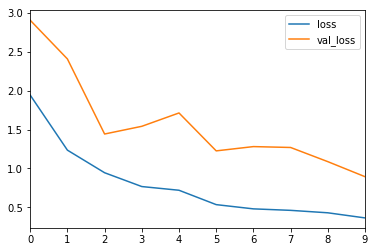

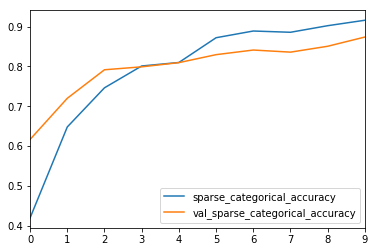

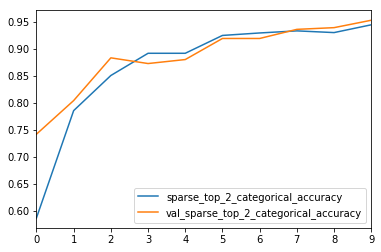

In [0]:
learner_xception_v0.show_history('loss')
learner_xception_v0.show_history('sparse_categorical_accuracy')
learner_xception_v0.show_history('sparse_top_2_categorical_accuracy')

## Second model - Xception

```
IMG_DIMS = (224, 224, 3)
lrs=(1e-4, 1e-4)
dropout=0.5
l1=3e-5,
l2=3e-4,
epochs=(5, 15)
```


In [0]:
learner_xception_v32 = ImageLearner(
    path=TEMP_DIR/"xception_v32",
    data=data_container_1,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=3e-5,
    l2=3e-4,
    load=True,
)

In [0]:
train_learner(learner_xception_v32, epochs=(5, 15))

Epoch 1/5
1425/1425 [==============================] - 101s 71ms/step - loss: 3.0154 - sparse_categorical_accuracy: 0.1091 - sparse_top_2_categorical_accuracy: 0.2070 - val_loss: 2.3972 - val_sparse_categorical_accuracy: 0.1453 - val_sparse_top_2_categorical_accuracy: 0.2916
Epoch 2/5
1425/1425 [==============================] - 97s 68ms/step - loss: 2.8498 - sparse_categorical_accuracy: 0.1333 - sparse_top_2_categorical_accuracy: 0.2491 - val_loss: 2.2677 - val_sparse_categorical_accuracy: 0.2000 - val_sparse_top_2_categorical_accuracy: 0.3600
Epoch 3/5
1425/1425 [==============================] - 97s 68ms/step - loss: 2.6925 - sparse_categorical_accuracy: 0.1561 - sparse_top_2_categorical_accuracy: 0.2747 - val_loss: 2.2255 - val_sparse_categorical_accuracy: 0.2189 - val_sparse_top_2_categorical_accuracy: 0.3842
Epoch 4/5
1425/1425 [==============================] - 96s 68ms/step - loss: 2.6313 - sparse_categorical_accuracy: 0.1807 - sparse_top_2_categorical_accuracy: 0.3074 - val_lo

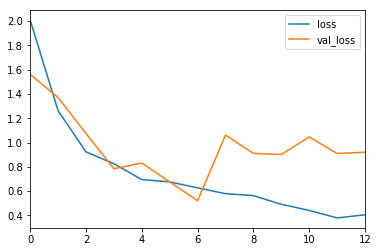

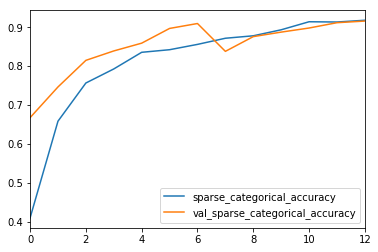

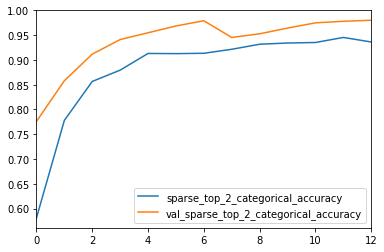

In [0]:
learner_xception_v32.show_history('loss')
learner_xception_v32.show_history('sparse_categorical_accuracy')
learner_xception_v32.show_history('sparse_top_2_categorical_accuracy')

In [0]:
learner_xception_v32.evaluate_dataset(mode="validation")

475/475 [==============================] - 19s 40ms/step - loss: 0.5210 - sparse_categorical_accuracy: 0.9095 - sparse_top_2_categorical_accuracy: 0.9789


[0.521030228969298, 0.90947366, 0.97894734]

In [0]:
print(classification_report(data_container_1.validation.y, learner_xception_v32.predict_dataset().argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.46      0.63      0.54        52
           1       0.97      0.99      0.98        78
           2       0.95      1.00      0.97        58
           3       0.99      0.93      0.96       122
           4       0.83      0.98      0.90        44
           5       0.99      0.98      0.98        95
           6       0.83      0.71      0.77       131
           7       0.94      1.00      0.97        44
           8       0.98      0.94      0.96       103
           9       0.90      0.94      0.92        47
          10       0.98      1.00      0.99        99
          11       0.99      0.90      0.94        77

    accuracy                           0.91       950
   macro avg       0.90      0.92      0.91       950
weighted avg       0.92      0.91      0.91       950



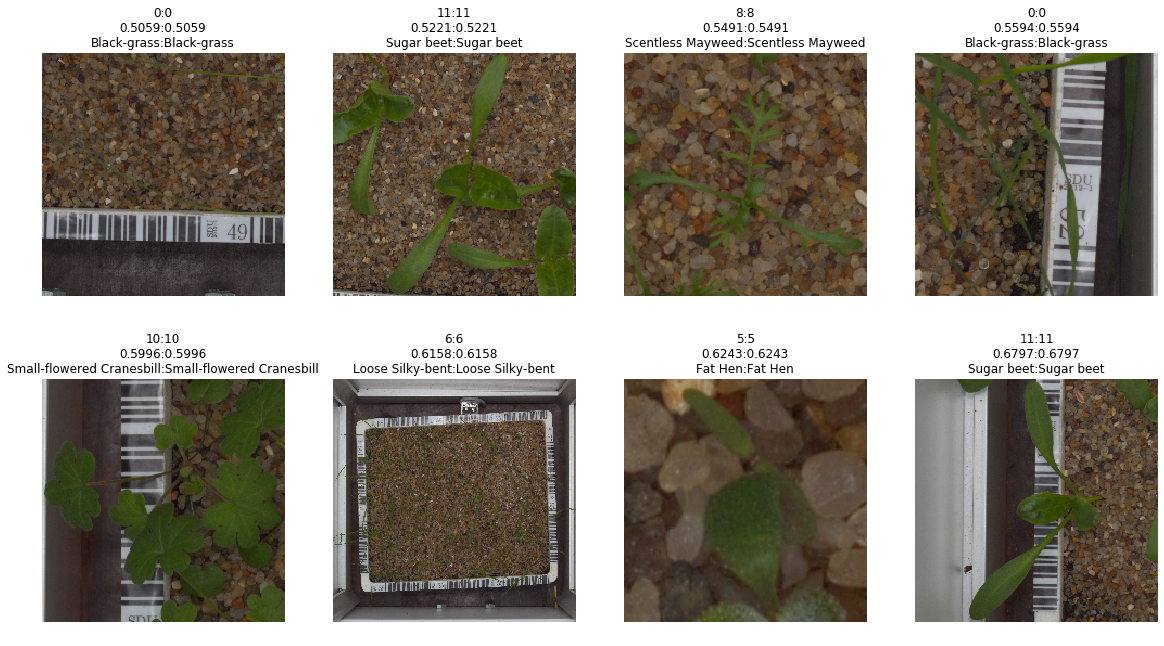

In [0]:
learner_xception_v32.show_predictions(correct=True, cols=4)

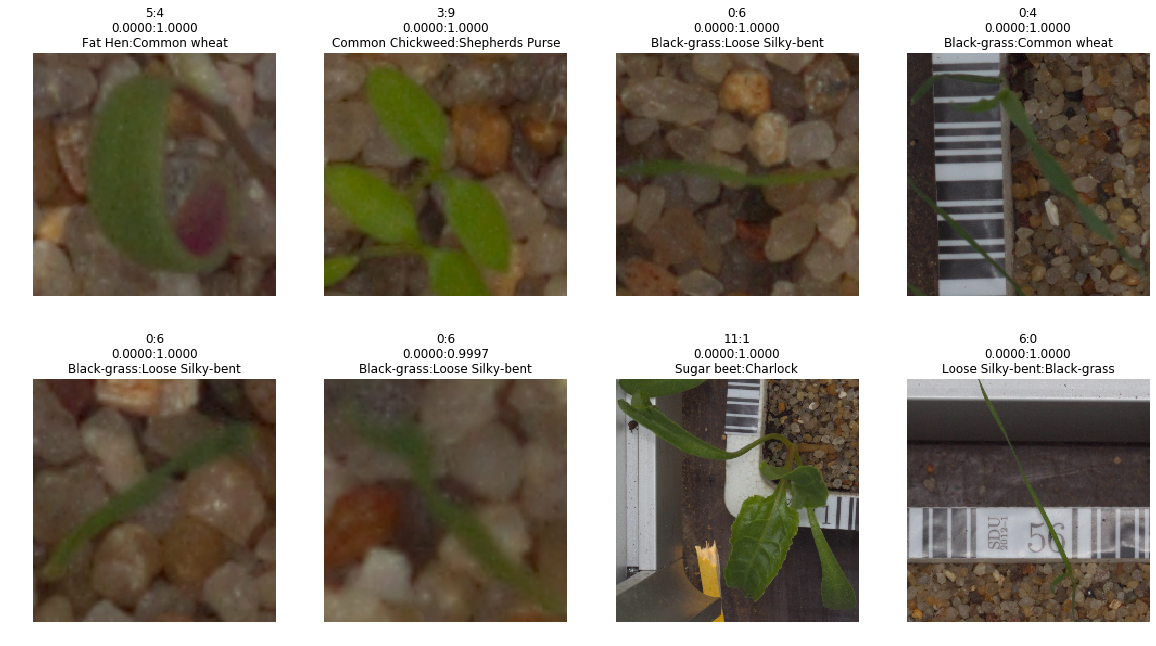

In [0]:
learner_xception_v32.show_predictions(cols=4)

## DenseNet121, MobileNetV2, EfficientNetB6

```
IMG_DIMS = (224, 224, 3)
lrs=(1e-4, 1e-4)
dropout=0.5
l1=3e-5,
l2=3e-4,
epochs=(5, 15)
```

In [0]:
LearnerParams = namedtuple("LearnerParams", ["path", "base"])

In [0]:
learners = []

for path, base_model in [
    
    LearnerParams(TEMP_DIR/"densenet121_v1", keras.applications.DenseNet121),
    LearnerParams(TEMP_DIR/"mobilenetv2_v1", keras.applications.MobileNetV2),
    
]:
    learner = ImageLearner(
        path=path,
        data=data_container,
        base_model=base_model,
        input_shape=IMG_DIMS,
        dropout=0.5,
        l1=3e-5,
        l2=3e-4,
        override=True,
        load=True,
    )
    train_learner(learner)
    learners.append(learner.history.history.copy())
    del learner

29089792/29084464 [==============================] - 2s 0us/step


W0901 04:33:13.197833 140089888425856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
1425/1425 [==============================] - 169s 118ms/step - loss: 1.0867 - sparse_categorical_accuracy: 0.6947 - sparse_top_2_categorical_accuracy: 0.8316 - val_loss: 0.4965 - val_sparse_categorical_accuracy: 0.8579 - val_sparse_top_2_categorical_accuracy: 0.9663
Epoch 2/5
1425/1425 [==============================] - 154s 108ms/step - loss: 1.0793 - sparse_categorical_accuracy: 0.6996 - sparse_top_2_categorical_accuracy: 0.8326 - val_loss: 0.5339 - val_sparse_categorical_accuracy: 0.8421 - val_sparse_top_2_categorical_accuracy: 0.9653
Epoch 3/5
1425/1425 [==============================] - 148s 104ms/step - loss: 1.0319 - sparse_categorical_accuracy: 0.7091 - sparse_top_2_categorical_accuracy: 0.8411 - val_loss: 0.5492 - val_sparse_categorical_accuracy: 0.8432 - val_sparse_top_2_categorical_accuracy: 0.9684
Epoch 4/5
1425/1425 [==============================] - 154s 108ms/step - loss: 1.0600 - sparse_categorical_accuracy: 0.7105 - sparse_top_2_categorical_accuracy: 0.8267 -

In [0]:
learner_efficient_v7 = ImageLearner(
    path=TEMP_DIR/"efficientnetb6_v7",
    data=data_container_1,
    base_model=efn.EfficientNetB6,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=3e-5,
    l2=3e-4,
    load=True,
)

In [0]:
train_learner(learner_efficient_v7, epochs=(5, 15))

W0901 04:24:56.844755 140436330981248 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
1425/1425 [==============================] - 144s 101ms/step - loss: 7.5338 - sparse_categorical_accuracy: 0.1168 - sparse_top_2_categorical_accuracy: 0.2214 - val_loss: 2.8351 - val_sparse_categorical_accuracy: 0.2495 - val_sparse_top_2_categorical_accuracy: 0.3989
Epoch 2/5
1425/1425 [==============================] - 121s 85ms/step - loss: 6.8365 - sparse_categorical_accuracy: 0.1554 - sparse_top_2_categorical_accuracy: 0.2744 - val_loss: 3.3767 - val_sparse_categorical_accuracy: 0.2274 - val_sparse_top_2_categorical_accuracy: 0.3926
Epoch 3/5
1425/1425 [==============================] - 122s 86ms/step - loss: 6.3820 - sparse_categorical_accuracy: 0.1709 - sparse_top_2_categorical_accuracy: 0.3025 - val_loss: 2.3864 - val_sparse_categorical_accuracy: 0.3537 - val_sparse_top_2_categorical_accuracy: 0.5368
Epoch 4/5
1425/1425 [==============================] - 121s 85ms/step - loss: 5.9701 - sparse_categorical_accuracy: 0.1961 - sparse_top_2_categorical_accuracy: 0.3379 - va

```
--------------------------------------------------------------------------------
Name: densenet121 Train Time: 128.0 min. Eval Time: 28.95s Loss: 0.4744 Accuracy: 89.26%
--------------------------------------------------------------------------------
```
```
--------------------------------------------------------------------------------
Name: mobilenetv2_1.00_224 Train Time: 63.3 min. Eval Time: 13.78s Loss: 1.6378 Accuracy: 50.00%
--------------------------------------------------------------------------------
```
```
--------------------------------------------------------------------------------
Name: efficientnet-b6 Train Time: 122.5 min. Eval Time: 24.49s Loss: 0.5075 Accuracy: 89.26%
--------------------------------------------------------------------------------
```



## HP tuning

In [0]:
IMG_DIMS = (99, 99, 3)

In [0]:
data_container_1 = DataContainer(
    train=ImageDataset(
        x=train_data[img_col].values,
        y=label_pipeline.transform(train_data[target_col]),
        batch_size=2,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=2, flips="both"),
        ],
        shuffle=True,
        prefetch=0,
        num_parallel_calls=1,
    ),
    validation=ImageDataset(
        x=val_data[img_col].values,
        y=label_pipeline.transform(val_data[target_col]),
        img_dims=IMG_DIMS,
        batch_size=2,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
        ],
        shuffle=False,
        prefetch=0,
        num_parallel_calls=-1,
    ),
    test=ImageDataset(
        x=test_data[img_col].values,
        y=label_pipeline.transform(test_data[target_col]),
        img_dims=IMG_DIMS,
        batch_size=2,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
        ],
        shuffle=False,
        prefetch=0,
        num_parallel_calls=-1,
    ),
)

In [0]:
class ImageLearner_for_HP:
    def __init__(
        self, path, data, base_model, input_shape, dropout=0.0, l1=1e-8, l2=1e-8, override=False, load=False,
    ):
        self.path = str(path)
        self.weights_path = f"{self.path}/weights.h5"
        self.architecture_path = f"{self.path}/model.json"
        
        self.best_model_arch_path =  str(TEMP_DIR/'best_model/best_model.json')
        self.best_model_weights_path = str(TEMP_DIR/'best_model/weights.json')
        
        self.logs_path = f"{self.path}/logs"

        self.data = data
        self.n_classes = data.train.n_classes
        self.input_shape = input_shape
        self.dropout = dropout
        self.l1 = l1
        self.l2 = l2

        self.base_model = base_model(include_top=False, input_shape=input_shape)
        x = keras.layers.concatenate(
            [
                keras.layers.GlobalAvgPool2D()(self.base_model.output),
                keras.layers.GlobalMaxPool2D()(self.base_model.output),
            ]
        )
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(dropout)(x)
        x = keras.layers.Dense(
            self.n_classes,
            kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
            activation=keras.activations.softmax,
        )(x)

        self.model = keras.Model(inputs=self.base_model.inputs, outputs=x)
        
        if os.path.exists(self.path):
            if load:
                self.load()
            elif override:
                shutil.rmtree(self.path)
                os.makedirs(self.path)
        else:
            os.makedirs(self.path)
            
        self.save()

    def save(self):
        save_keras_model(self.model, self.architecture_path, self.weights_path)
    
    def save_best_hp(self):
        save_keras_model(self.model, self.best_model_arch_path, self.best_model_weights_path)


    def load(self, weights_only=False):
        if weights_only:
            self.model.load_weights(self.weights_path)
        else:
            self.model = load_keras_model(self.architecture_path, self.weights_path)

    def compile(self, optimizer, lr):
        self.model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
               
                keras.metrics.sparse_categorical_accuracy
            
            ],
        )

    def freeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = False

    def unfreeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = True

    def train(self, epochs, verbose=1):
        reduce_lr_patience = max(2, epochs // 4)
        early_stopping_patience = reduce_lr_patience * 2

        self.history = self.model.fit(
            x=self.data.train.data,
            steps_per_epoch=self.data.train.steps,
            validation_data=self.data.validation.data,
            validation_steps=self.data.validation.steps,
            epochs=epochs,
            callbacks=[
                keras.callbacks.ModelCheckpoint(
                    self.weights_path, save_best_only=True, save_weights_only=True
                ),
                keras.callbacks.ReduceLROnPlateau(
                    factor=0.3, patience=reduce_lr_patience, 
                ),
                keras.callbacks.EarlyStopping(
                    patience=early_stopping_patience, restore_best_weights=True
                ),
            ],
            verbose=verbose,
        )
        self.load(weights_only=True)

    def evaluate_dataset(self, mode="validation", verbose=1):
        dataset = getattr(self.data, mode)
        return self.model.evaluate(dataset.data, steps=dataset.steps, verbose=verbose)

    def predict_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        return self.model.predict(dataset.data, steps=dataset.steps, verbose=verbose)
    
    def analyse_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        image_ds = tf.data.Dataset.from_tensor_slices(dataset.x)
        image_ds = dataset.preprocess(image_ds, 1).batch(1)
        images = [image[0].numpy() for image in image_ds.take(dataset.length)] 
        probs = self.model.predict(image_ds)
        preds = probs.argmax(axis=1)
        return pd.DataFrame.from_dict({
            "path": dataset.x,
            "image": images,
            "label": dataset.y, 
            "pred": preds,
            "label_probs": probs[:, dataset.y][np.eye(dataset.length, dtype=bool)],
            "pred_probs": probs[:, preds][np.eye(dataset.length, dtype=bool)],
        })
    
    def predict(self, path=None, image=None):
        if image is None:
            image = tf.data.Dataset.from_tensor_slices([path])
            image = self.data.test.preprocess(image, 1).batch(1)
        elif image.ndim == 3:
            image = image[np.newaxis, :]
        return self.model.predict(image)
    
    def show_predictions(self, mode="validation", correct: bool = False, ascending: bool = True, cols: int = 8, rows: int = 2):
        df = self.analyse_dataset(mode=mode)
        df = df[(df.label == df.pred) if correct else (df.label != df.pred)]
        df.sort_values(by=["label_probs"], ascending=ascending, inplace=True)
        _, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3.5 * rows))
        for i, row in enumerate(df.head(cols * rows).itertuples()):
            idx = (i // cols, i % cols) if rows > 1 else i % cols
            ax[idx].axis("off")
            ax[idx].imshow(row.image)
            ax[idx].set_title(f"{row.label}:{row.pred}\n{row.label_probs:.4f}:{row.pred_probs:.4f}")
        

    def show_history(self, contains, skip=0):
        history_df = pd.DataFrame(self.history.history)
        history_df[list(history_df.filter(regex=contains))].iloc[skip:].plot()

In [0]:
dimensions = [
#     skopt.space.Categorical([
#         keras.optimizers.Adam,
#         keras.optimizers.Nadam,
#         keras.optimizers.RMSprop,
#     ], name='optimizer'),
    skopt.space.Real(low=1e-6, high=1e-3, prior='log-uniform', name='lr'),
    skopt.space.Real(low=0., high=0.5, name='dropout'),
#     skopt.space.Real(low=1e-8, high=1e-2, prior='log-uniform', name='l1_reg'),
#     skopt.space.Real(low=1e-8, high=1e-2, prior='log-uniform', name='l2_reg'),
    skopt.space.Integer(low=5, high=10, name='epochs'),
#     skopt.space.Integer(low=0, high=5, name='easing_epochs'),
]

In [0]:
default_parameters = [1e-4, 0.2, 5]

In [0]:
def train_learner_for_HP(learner, epochs=(1, 15), lrs=(1e-4, 1e-4)):
    start_time = time.time()
    learner.freeze()
    learner.compile(keras.optimizers.Adam, lrs[0])
    learner.train(epochs[0])
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, lrs[1])
    learner.train(epochs[1])
    end_time = time.time()

    eval_start_time = time.time()
    loss, accuracy = learner.evaluate_dataset(verbose=0)

    eval_end_time = time.time()

    print("-".center(80, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))
    
    return accuracy

In [0]:
best_accuracy = 0.0

In [0]:
@skopt.utils.use_named_args(dimensions=dimensions)
def fitness(
    lr,
    dropout,
    epochs,
):  
    learner_xception_v5 = ImageLearner_for_HP(
        path=TEMP_DIR/"xception_v5",
        data=data_container_1,
        base_model=keras.applications.Xception,
        input_shape=IMG_DIMS,
        dropout=dropout,
        l1=3e-5,
        l2=3e-4,
        override=True,
        load=True,
    )
    
    accuracy = train_learner_for_HP(learner_xception_v5, epochs=(3, epochs), lrs=(lr, lr))


    print("\nAccuracy: {0:.2%}\n".format(accuracy))

    global best_accuracy

    if accuracy > best_accuracy:
        print('Best model'.center(80, '-'))
        print("Accuracy: {0:.4%}".format(accuracy))
        print(
            lr,
            dropout,
            epochs,
        )
        learner_xception_v5.save_best_hp()
        pd.DataFrame.from_dict({
           "lr": lr,
           "dropout": dropout,
           "epochs": epochs, 
        },orient='index').to_csv(TEMP_DIR/'best_model/best_model_params.csv')

        best_accuracy = accuracy

    del learner_xception_v5

    keras.backend.clear_session()

    return -accuracy

In [0]:
search_result = skopt.gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI',
    n_calls=11,
    x0=default_parameters,
)

Epoch 1/3
1425/1425 [==============================] - 69s 49ms/step - loss: 2.6057 - sparse_categorical_accuracy: 0.1200 - val_loss: 2.4883 - val_sparse_categorical_accuracy: 0.1474
Epoch 2/3
1425/1425 [==============================] - 66s 47ms/step - loss: 2.5745 - sparse_categorical_accuracy: 0.1302 - val_loss: 2.4452 - val_sparse_categorical_accuracy: 0.1663
Epoch 3/3
1425/1425 [==============================] - 67s 47ms/step - loss: 2.5276 - sparse_categorical_accuracy: 0.1491 - val_loss: 2.4240 - val_sparse_categorical_accuracy: 0.1611
Epoch 1/5
1425/1425 [==============================] - 214s 150ms/step - loss: 2.7578 - sparse_categorical_accuracy: 0.1600 - val_loss: 5.9936 - val_sparse_categorical_accuracy: 0.2453
Epoch 2/5
1425/1425 [==============================] - 167s 117ms/step - loss: 2.4134 - sparse_categorical_accuracy: 0.2519 - val_loss: 5.7147 - val_sparse_categorical_accuracy: 0.3168
Epoch 3/5
1425/1425 [==============================] - 166s 116ms/step - loss: 1.



```
-----------------------------------Best model-----------------------------------
Accuracy: 85.3684%
lr = 2.201923472028716e-05 
dropout = 0.229948292173897 
epochs = 9
```



## Third model - Xception

```
IMG_DIMS = (299, 299, 3)
lrs=(2e-5, 2e-5, 1e-5) # Adding last layer - SGD
dropout=0.3
l1=1e-4,
l2=3e-3,
epochs=(5, 15, 5)
```



In [0]:
IMG_DIMS = (299, 299, 3)

In [0]:
def train_learner_sgd(learner, epochs=(5, 15, 5), lrs=(1e-4, 1e-4, 1e-5)):
    start_time = time.time()
    learner.freeze()
    learner.compile(keras.optimizers.Adam, lrs[0])
    learner.train(epochs[0])
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, lrs[1])
    learner.train(epochs[1])
    learner.compile(keras.optimizers.SGD, lrs[2])
    learner.train(epochs[2])


    end_time = time.time()

    eval_start_time = time.time()
    loss, accuracy, top_2_accuracy = learner.evaluate_dataset(verbose=0)

    eval_end_time = time.time()

    print("-".center(80, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))

In [0]:
learner_xception_v11 = ImageLearner(
    path=TEMP_DIR/"xception_v11",
    data=data_container_1,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    dropout=0.3,
    l1=1e-4,
    l2=3e-3,
    load=True,
)

In [0]:
train_learner_sgd(learner_xception_v11, epochs=(5, 15, 5), lrs=(2e-5, 2e-5, 1e-5))

Epoch 1/5
1425/1425 [==============================] - 66s 46ms/step - loss: 0.4202 - sparse_categorical_accuracy: 0.9221 - sparse_top_2_categorical_accuracy: 0.9681 - val_loss: 0.5800 - val_sparse_categorical_accuracy: 0.9053 - val_sparse_top_2_categorical_accuracy: 0.9789
Epoch 2/5
1425/1425 [==============================] - 64s 45ms/step - loss: 0.3769 - sparse_categorical_accuracy: 0.9267 - sparse_top_2_categorical_accuracy: 0.9691 - val_loss: 0.5598 - val_sparse_categorical_accuracy: 0.9011 - val_sparse_top_2_categorical_accuracy: 0.9789
Epoch 3/5
1425/1425 [==============================] - 63s 44ms/step - loss: 0.3628 - sparse_categorical_accuracy: 0.9368 - sparse_top_2_categorical_accuracy: 0.9723 - val_loss: 0.5601 - val_sparse_categorical_accuracy: 0.8979 - val_sparse_top_2_categorical_accuracy: 0.9800
Epoch 4/5
1425/1425 [==============================] - 63s 44ms/step - loss: 0.3744 - sparse_categorical_accuracy: 0.9312 - sparse_top_2_categorical_accuracy: 0.9716 - val_los

## Fourth model - Xception

```
IMG_DIMS = (299, 299, 3)
lrs=(1e-4, 1e-54, 1e-5)
dropout=0.5
l1=1e-4,
l2=3e-3,
epochs=(5, 30, 5)
```



In [0]:
learner_xception_v12 = ImageLearner(
    path=TEMP_DIR/"xception_v12",
    data=data_container_1,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=1e-4,
    l2=3e-3,
    load=True,
)

In [0]:
train_learner_sgd(learner_xception_v12, epochs=(5, 30, 5))

W0831 14:47:06.066738 140690780084096 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
1425/1425 [==============================] - 71s 50ms/step - loss: 3.0613 - sparse_categorical_accuracy: 0.1916 - sparse_top_2_categorical_accuracy: 0.3354 - val_loss: 2.2989 - val_sparse_categorical_accuracy: 0.2758 - val_sparse_top_2_categorical_accuracy: 0.4358
Epoch 2/5
1425/1425 [==============================] - 64s 45ms/step - loss: 2.5146 - sparse_categorical_accuracy: 0.3154 - sparse_top_2_categorical_accuracy: 0.4863 - val_loss: 2.1738 - val_sparse_categorical_accuracy: 0.3400 - val_sparse_top_2_categorical_accuracy: 0.4737
Epoch 3/5
1425/1425 [==============================] - 65s 46ms/step - loss: 2.3158 - sparse_categorical_accuracy: 0.3779 - sparse_top_2_categorical_accuracy: 0.5456 - val_loss: 2.1296 - val_sparse_categorical_accuracy: 0.3421 - val_sparse_top_2_categorical_accuracy: 0.4895
Epoch 4/5
1425/1425 [==============================] - 64s 45ms/step - loss: 2.2072 - sparse_categorical_accuracy: 0.3930 - sparse_top_2_categorical_accuracy: 0.5818 - val_los

## Model Xception with no Xception weights

```
IMG_DIMS = (299, 299, 3)
lrs=(1e-4, 1e-4)
dropout=0.5
l1=1e-4,
l2=3e-3,
epochs=(3, 10)
```


In [0]:
class ImageLearner_no_w:
    def __init__(
        self, path, data, base_model, input_shape, dropout=0.0, l1=1e-8, l2=1e-8, override=False, load=False,
    ):
        self.path = str(path)
        self.weights_path = f"{self.path}/weights.h5"
        self.architecture_path = f"{self.path}/model.json"
        self.logs_path = f"{self.path}/logs"

        self.data = data
        self.n_classes = data.train.n_classes
        self.input_shape = input_shape
        self.dropout = dropout
        self.l1 = l1
        self.l2 = l2

        self.base_model = base_model(include_top=False, weights=None, input_shape=input_shape)
        x = keras.layers.concatenate(
            [
                keras.layers.GlobalAvgPool2D()(self.base_model.output),
                keras.layers.GlobalMaxPool2D()(self.base_model.output),
            ]
        )
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(dropout)(x)
        x = keras.layers.Dense(
            self.n_classes,
            kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
            activation=keras.activations.softmax,
        )(x)

        self.model = keras.Model(inputs=self.base_model.inputs, outputs=x)
        
        if os.path.exists(self.path):
            if load:
                self.load()
            elif override:
                shutil.rmtree(self.path)
                os.makedirs(self.path)
        else:
            os.makedirs(self.path)
            
        self.save()

    def save(self):
        save_keras_model(self.model, self.architecture_path, self.weights_path)

    def load(self, weights_only=False):
        if weights_only:
            self.model.load_weights(self.weights_path)
        else:
            self.model = load_keras_model(self.architecture_path, self.weights_path)

    def compile(self, optimizer, lr):
        self.model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
               
                keras.metrics.sparse_categorical_accuracy,
                sparse_top_2_categorical_accuracy, 
            
            ],
        )

    def freeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = False

    def unfreeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = True

    def train(self, epochs, verbose=1):
        reduce_lr_patience = max(2, epochs // 4)
        early_stopping_patience = reduce_lr_patience * 2

        self.history = self.model.fit(
            x=self.data.train.data,
            steps_per_epoch=self.data.train.steps,
            validation_data=self.data.validation.data,
            validation_steps=self.data.validation.steps,
            epochs=epochs,
            callbacks=[
                keras.callbacks.ModelCheckpoint(
                    self.weights_path, save_best_only=True, save_weights_only=True
                ),
                keras.callbacks.ReduceLROnPlateau(
                    factor=0.3, patience=reduce_lr_patience, 
                ),
                keras.callbacks.EarlyStopping(
                    patience=early_stopping_patience, restore_best_weights=True
                ),
            ],
            verbose=verbose,
        )
        self.load(weights_only=True)

    def evaluate_dataset(self, mode="validation", verbose=1):
        dataset = getattr(self.data, mode)
        return self.model.evaluate(dataset.data, steps=dataset.steps, verbose=verbose)

    def predict_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        return self.model.predict(dataset.data, steps=dataset.steps, verbose=verbose)
    
    def analyse_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        image_ds = tf.data.Dataset.from_tensor_slices(dataset.x)
        image_ds = dataset.preprocess(image_ds, 1).batch(1)
        images = [image[0].numpy() for image in image_ds.take(dataset.length)] # DIFFERENT THAN IN LESSON 1!!!
        probs = self.model.predict(image_ds)
        preds = probs.argmax(axis=1)
        return pd.DataFrame.from_dict({
            "path": dataset.x,
            "image": images,
            "label": dataset.y, 
            "pred": preds,
            "label_word": label_pipeline.inverse_transform(dataset.y),
            "pred_word": label_pipeline.inverse_transform(preds),
            "label_probs": probs[:, dataset.y][np.eye(dataset.length, dtype=bool)], # DIFFERENT THAN IN LESSON 1!!!
            "pred_probs": probs[:, preds][np.eye(dataset.length, dtype=bool)], # DIFFERENT THAN IN LESSON 1!!!
        })
    
    def predict(self, path=None, image=None):
        if image is None:
            image = tf.data.Dataset.from_tensor_slices([path])
            image = self.data.test.preprocess(image, 1).batch(1)
        elif image.ndim == 3:
            image = image[np.newaxis, :]
        return self.model.predict(image)
    
    def show_predictions(self, mode="validation", correct: bool = False, ascending: bool = True, cols: int = 8, rows: int = 2):
        df = self.analyse_dataset(mode=mode)
        df = df[(df.label == df.pred) if correct else (df.label != df.pred)]
        df.sort_values(by=["label_probs"], ascending=ascending, inplace=True)
        _, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3.5 * rows))
        for i, row in enumerate(df.head(cols * rows).itertuples()):
            idx = (i // cols, i % cols) if rows > 1 else i % cols
            ax[idx].axis("off")
            ax[idx].imshow(row.image)
            ax[idx].set_title(f"{row.label}:{row.pred}\n{row.label_probs:.4f}:{row.pred_probs:.4f}\n{row.label_word}:{row.pred_word}") #I added \n{row.label_word}:{row.pred_word}
        

    def show_history(self, contains, skip=0):
        history_df = pd.DataFrame(self.history.history)
        history_df[list(history_df.filter(regex=contains))].iloc[skip:].plot()

In [0]:
learner_xception_v_no = ImageLearner_no_w(
    path=TEMP_DIR/"xception_no",
    data=data_container_1,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=1e-4,
    l2=3e-3,
    load=True,
)

In [0]:
train_learner(learner_xception_v_no, epochs=(3, 10))

Epoch 1/3
1425/1425 [==============================] - 63s 44ms/step - loss: 3.0797 - sparse_categorical_accuracy: 0.1014 - sparse_top_2_categorical_accuracy: 0.2011 - val_loss: 2.6434 - val_sparse_categorical_accuracy: 0.1084 - val_sparse_top_2_categorical_accuracy: 0.2368
Epoch 2/3
1425/1425 [==============================] - 61s 43ms/step - loss: 2.9963 - sparse_categorical_accuracy: 0.1193 - sparse_top_2_categorical_accuracy: 0.2161 - val_loss: 2.6373 - val_sparse_categorical_accuracy: 0.1084 - val_sparse_top_2_categorical_accuracy: 0.2463
Epoch 3/3
1425/1425 [==============================] - 60s 42ms/step - loss: 2.9766 - sparse_categorical_accuracy: 0.1109 - sparse_top_2_categorical_accuracy: 0.2204 - val_loss: 2.6315 - val_sparse_categorical_accuracy: 0.1379 - val_sparse_top_2_categorical_accuracy: 0.1989
Epoch 1/10
1425/1425 [==============================] - 212s 149ms/step - loss: 3.2500 - sparse_categorical_accuracy: 0.1512 - sparse_top_2_categorical_accuracy: 0.2737 - val_

## Final Model - Xception

```
IMG_DIMS = (299, 299, 3)
lrs=(1e-4, 1e-4)
dropout=0.5
l1=1e-4,
l2=3e-3,
epochs=(7, 35)
```



In [0]:
learner_xception_v15 = ImageLearner(
    path=TEMP_DIR/"xception_15",
    data=data_container_1,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=1e-4,
    l2=3e-3,
    load=True,
)

In [0]:
train_learner(learner_xception_v15, epochs=(7, 35))

In [0]:
train_learner(learner_xception_v15, epochs=(0, 0))

--------------------------------------------------------------------------------
Name: xception Train Time: 0.1 min. Eval Time: 27.74s Loss: 0.3977 Accuracy: 95.68%
--------------------------------------------------------------------------------


In [0]:
learner_xception_v15.evaluate_dataset(mode="validation")

475/475 [==============================] - 27s 57ms/step - loss: 0.3977 - sparse_categorical_accuracy: 0.9568 - sparse_top_2_categorical_accuracy: 0.9853


[0.3976859821928175, 0.9568421, 0.98526317]

In [0]:
learner_xception_v15.evaluate_dataset(mode="test")

475/475 [==============================] - 28s 59ms/step - loss: 0.5802 - sparse_categorical_accuracy: 0.9305 - sparse_top_2_categorical_accuracy: 0.9832


[0.5802347234048342, 0.9305263, 0.9831579]

In [0]:
print(classification_report(data_container_1.validation.y, learner_xception_v15.predict_dataset().argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70        52
           1       1.00      1.00      1.00        78
           2       1.00      0.98      0.99        58
           3       0.98      0.98      0.98       122
           4       0.90      1.00      0.95        44
           5       0.99      0.99      0.99        95
           6       0.90      0.87      0.88       131
           7       1.00      1.00      1.00        44
           8       0.98      0.98      0.98       103
           9       1.00      0.96      0.98        47
          10       1.00      1.00      1.00        99
          11       1.00      0.99      0.99        77

    accuracy                           0.96       950
   macro avg       0.95      0.96      0.95       950
weighted avg       0.96      0.96      0.96       950



In [0]:
print(classification_report(data_container_1.test.y, learner_xception_v15.predict_dataset(mode='test').argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.56      0.66      0.61        53
           1       0.99      0.99      0.99        78
           2       1.00      0.95      0.97        57
           3       0.98      0.98      0.98       122
           4       0.81      0.96      0.88        45
           5       0.96      0.99      0.97        95
           6       0.88      0.77      0.82       131
           7       0.98      1.00      0.99        44
           8       0.94      0.97      0.96       103
           9       1.00      0.89      0.94        46
          10       1.00      1.00      1.00        99
          11       0.99      0.99      0.99        77

    accuracy                           0.93       950
   macro avg       0.92      0.93      0.93       950
weighted avg       0.93      0.93      0.93       950



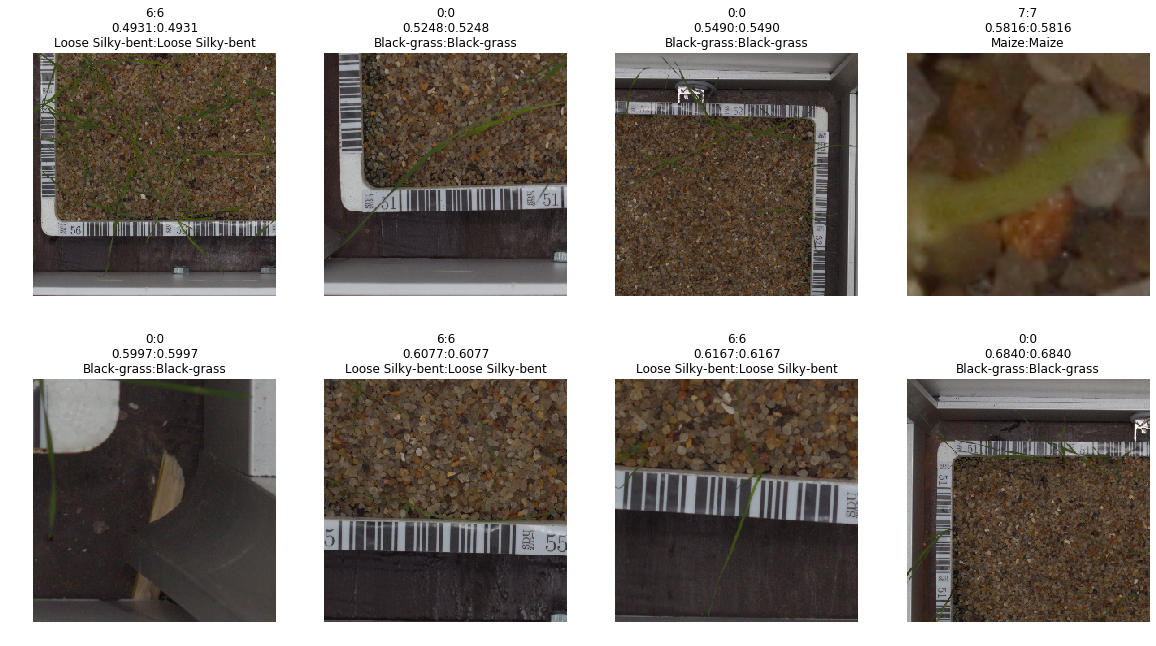

In [0]:
learner_xception_v15.show_predictions(mode="test", correct=True, cols=4)

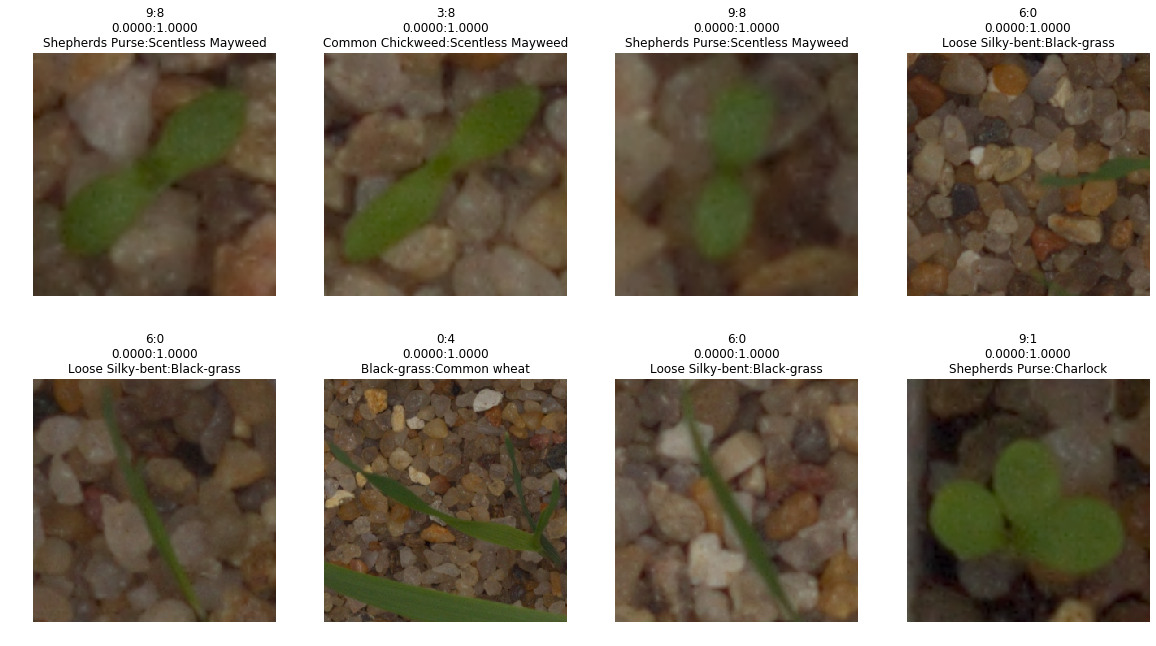

In [0]:
learner_xception_v15.show_predictions(mode="test", cols=4)

# Predicting Kaggle competition set (unlabeled images)

## Reading and exploring the data

In [0]:
!unzip -q {str(DATA_DIR)}/test.zip -d {str(DATA_DIR)}

In [0]:
def make_df_from_dir_no_labels(path):
    data1 = {
        'image': [],
        'path':[],
        'shape': [], 
    }
    for item in os.listdir(DATA_DIR/path):
        data1['image'].append(f"{item}")
        data1['path'].append(DATA_DIR/path/item)            
        data1['shape'].append(np.array(Image.open(DATA_DIR/path/item)).shape)
            
        
    return pd.DataFrame(data1)

In [0]:
predict_no_labels_df = make_df_from_dir_no_labels('test')

In [0]:
predict_no_labels_df.head()

image                            path          shape
0  a85b48a95.png  data/plants/test/a85b48a95.png  (282, 282, 3)
1  a544fc46d.png  data/plants/test/a544fc46d.png  (245, 245, 3)
2  a800caead.png  data/plants/test/a800caead.png  (328, 328, 3)
3  bb20fce02.png  data/plants/test/bb20fce02.png  (233, 233, 3)
4  855955aaf.png  data/plants/test/855955aaf.png  (222, 222, 3)

In [0]:
predict_no_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 3 columns):
image    794 non-null object
path     794 non-null object
shape    794 non-null object
dtypes: object(3)
memory usage: 18.7+ KB


In [0]:
predict_no_labels_df.to_csv(str(TEMP_DIR/'predict_no_labels_df.csv'), index=False)

## Predicting with Final Model

In [0]:
def make_predictions_df(df, learner, path_col='path', image_col='image'):
    data1 = {
        'file': [],
        'species':[],
    }
    
    for i in range(len(df)):
        data1['file'].append(df[image_col][i])
        data1['species'].append(''.join(label_pipeline.inverse_transform(learner.predict(str(df[path_col][i])).argmax(axis=1))))    


    return pd.DataFrame(data1)

In [0]:
predictions = make_predictions_df(predict_no_labels_df, learner_xception_v15)

In [0]:
predictions.head(3)

file            species
0  a85b48a95.png  Scentless Mayweed
1  a544fc46d.png  Scentless Mayweed
2  a800caead.png         Sugar beet

In [0]:
predictions.to_csv(TEMP_DIR/'predictions.csv', index=False)

In [0]:
predictions = pd.read_csv(TEMP_DIR/'predictions.csv')

## Unlabeled images prediction analysis

### Distribution by category

In [0]:
predictions.groupby('species')['file'].nunique()


species
Black-grass                   54
Charlock                      62
Cleavers                      47
Common Chickweed             102
Common wheat                  35
Fat Hen                       64
Loose Silky-bent             104
Maize                         36
Scentless Mayweed             89
Shepherds Purse               43
Small-flowered Cranesbill     80
Sugar beet                    78
Name: file, dtype: int64

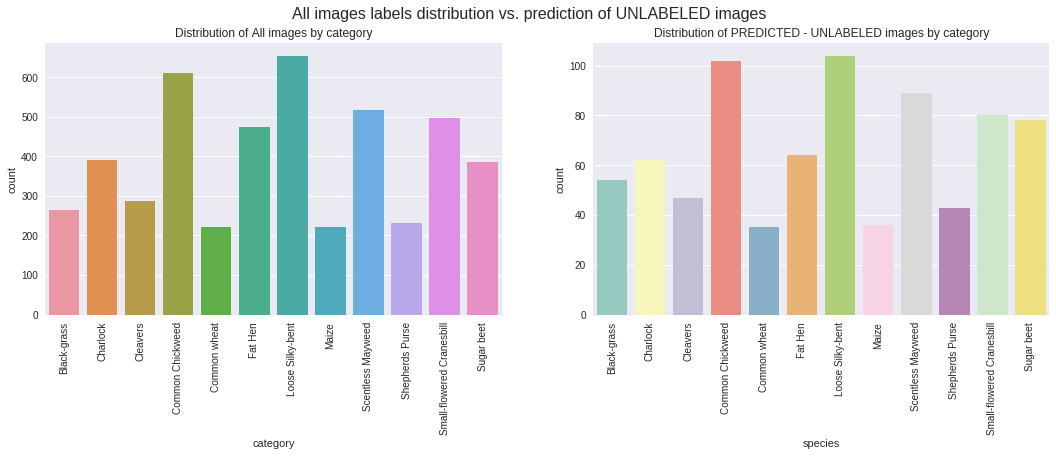

In [28]:
f, ax = plt.subplots(1, 2, figsize=(18, 5))
plt.style.use('seaborn')
f.suptitle('All images labels distribution vs. prediction of UNLABELED images ', fontsize=16)
sns.countplot(df_full['category'].sort_values(),data=df_full, ax=ax[0])
sns.countplot(predictions['species'].sort_values(),data=predictions, ax=ax[1], palette="Set3")
ax[0].set_title('Distribution of All images by category')
ax[1].set_title('Distribution of PREDICTED - UNLABELED images by category')
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)


### Plotting random images and showing predicted label

In [0]:
predictions['image'] = predictions['file']

In [0]:
predict_no_labels_df_with_pred = predict_no_labels_df.merge(predictions, on='image')

In [0]:
def plot_df_images(df, path_col, label_col=False, n_rows=3, n_columns=4, pred_col=False):
    f,ax = plt.subplots(n_rows,n_columns, figsize=(4 * n_columns, 4 * n_rows))
    for i in range(n_rows*n_columns):
        rand_int = np.random.randint(len(df.index))
        ax[i // n_columns, i % n_columns].imshow(np.array(Image.open(df[path_col][rand_int])))
        ax[i // n_columns, i % n_columns].axis('off')
        
        if pred_col:
            ax[i // n_columns, i % n_columns].set_title(f"label: {df[label_col][rand_int]}, pred: {df[pred_col][rand_int]}")
        else:
            ax[i // n_columns, i % n_columns].set_title(df[label_col][rand_int])

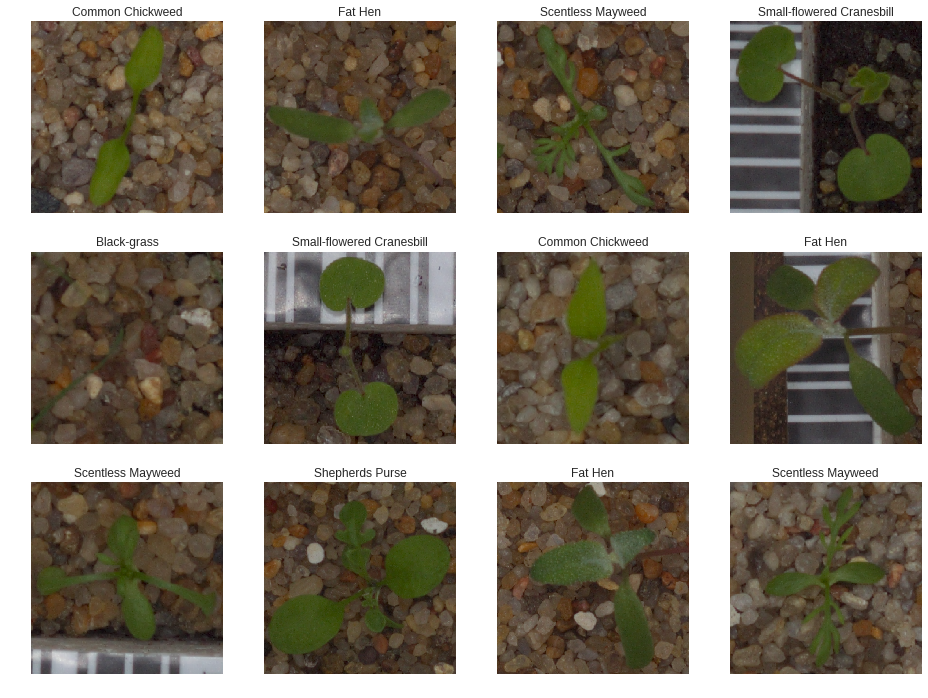

In [0]:
plot_df_images(predict_no_labels_df_with_pred, 'path', 'species')

## Kaggle submission score

0.95465